### Tweak 1: Regularization — Baseline vs. BatchNorm 

#### 1.1 Environment Check

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [5]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4
VRAM            : 15.6 GB


#### 1.2 The Subset

In [6]:
def get_cifar10_subsets(n_train=5000, n_test=1000, batch_size=64, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    full_train = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=transform)
    full_test = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=transform)

    train_subset = Subset(full_train, range(n_train))
    test_subset  = Subset(full_test,  range(n_test))

    train_loader = DataLoader(train_subset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(test_subset,  batch_size=batch_size,
                              shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_train.classes

In [7]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64


#### 1.3 Evaluation Suite

In [8]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [11]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} \u2014 Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} \u2014 Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

---
#### 2. Model Definitions


#### 2.2 Model B - BatchNorm

Adds `BatchNorm2d` after each Conv layer and `BatchNorm1d` after the first FC layer.

In [12]:
class SimpleCNN_BatchNorm(nn.Module):
    """
    Model B: baseline + BatchNorm after every Conv/FC layer.
    """

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
model = SimpleCNN_BatchNorm().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

SimpleCNN_BatchNorm(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Trainable parameters: 269,002


---
#### 3. Train the Models

Same hyperparameters for all: **Adam (lr=0.001)** \u00b7 **CrossEntropyLoss** \u00b7 **15 epochs** \u00b7 **batch size 64**

In [14]:
EPOCHS = 15 # complete pass through your entire training dataset
LR = 1e-3   # Learning Rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'Optimizer : Adam (lr={LR})')
print(f'Loss fn   : CrossEntropyLoss')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer : Adam (lr=0.001)
Loss fn   : CrossEntropyLoss
Epochs    : 15
Device    : cuda
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 1.6168  Acc: 42.66%  |  Val Loss: 1.4588  Acc: 47.20%
Epoch   2/15  |  Train Loss: 1.1656  Acc: 60.44%  |  Val Loss: 1.2808  Acc: 54.10%
Epoch   3/15  |  Train Loss: 0.8909  Acc: 70.36%  |  Val Loss: 1.3191  Acc: 54.50%
Epoch   4/15  |  Train Loss: 0.6751  Acc: 79.24%  |  Val Loss: 1.1896  Acc: 56.60%
Epoch   5/15  |  Train Loss: 0.4673  Acc: 87.76%  |  Val Loss: 1.3363  Acc: 54.90%
Epoch   6/15  |  Train Loss: 0.3304  Acc: 92.26%  |  Val Loss: 1.3446  Acc: 54.60%
Epoch   7/15  |  Train Loss: 0.2357  Acc: 95.52%  |  Val Loss: 1.4139  Acc: 54.30%
Epoch   8/15  |  Train Loss: 0.1852  Acc: 96.54%  |  Val Loss: 1.4402  Acc: 55.20%
Epoch   9/15  |  Train Loss: 0.0928  Acc: 98.92%  |  Val Loss: 1.4843  Acc: 55.90%
Epoch  10/15  |  Train Loss: 0.0958  Acc: 98.76%  |  Val Loss: 1.5392  Acc: 53.70%
Epoch  11/15  |

---
### 4. Individual Training Curves

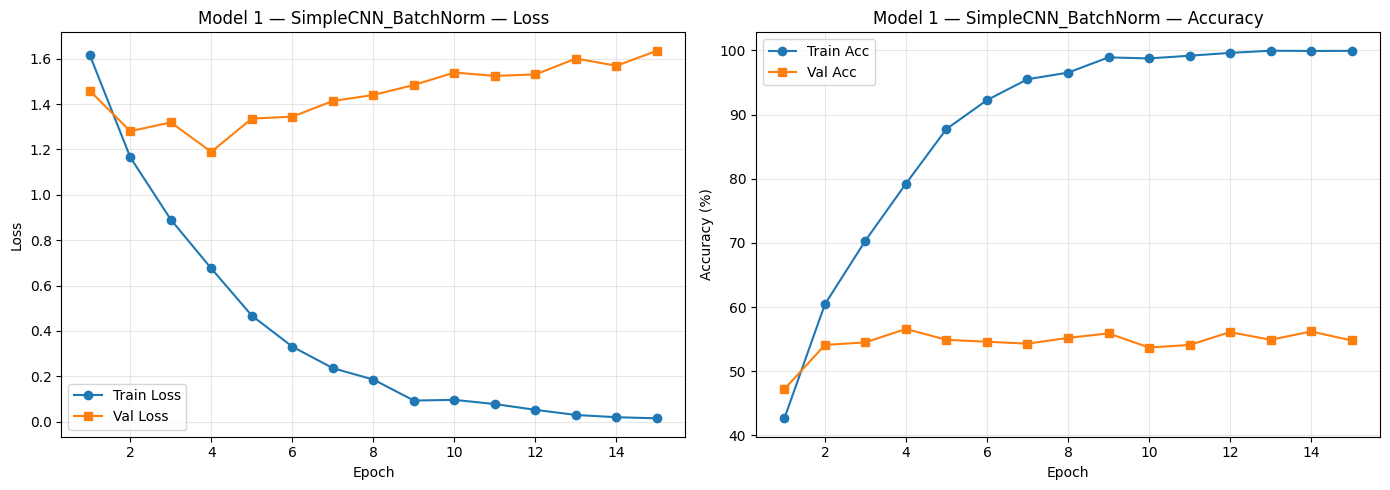

In [15]:
plot_history(history, title='Model 1 — SimpleCNN_BatchNorm')

---
### 5. Results Summary Table

In [16]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 50)
print('         MODEL 1 — RESULTS SUMMARY')
print('=' * 50)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print(f'  Diagnosis      : Worse overfitting — BatchNorm accelerates convergence but the model fits noise faster without any regulariser to stop it.')
print('=' * 50)

         MODEL 1 — RESULTS SUMMARY
  Parameters       : 269,002
  Final Train Acc  : 99.94%
  Final Val Acc    : 54.80%
  Peak Val Acc     : 56.60%
  Train-Val Gap    : +45.14%
  Final Train Loss : 0.0144
  Final Val Loss   : 1.6354
  Diagnosis      : Worse overfitting — BatchNorm accelerates convergence but the model fits noise faster without any regulariser to stop it.
